In [1]:
#As we dont have any GPU we will be using google collab for GPU usage
#Mout at drive 
import sys
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
import pandas as pd
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from string import punctuation
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/"

In [5]:
labeled_df1 = pd.read_csv(path + "dataset/Labeled/data.csv")
labeled_df2 = pd.read_csv(path + "dataset/Labeled/suicidal_data.csv")

In [6]:
unlabeled_df1 = pd.read_csv(path + "dataset/Unlabeled/TwitterRawData.csv",names=['text'], sep=',',delimiter=None)
unlabeled_df2 = pd.read_csv(path + "dataset/Unlabeled/suicideTweetData.csv",names=['text','label'], sep=',',delimiter=None)

**Labeled Data Marge**

In [7]:
labeled_df1.head()

,label,text
0,__label__suicidal,my life is meaningless i just want to end my l...
1,__label__suicidal,muttering i wanna die to myself daily for a fe...
2,__label__suicidal,work slave i really feel like my only purpose ...
3,__label__suicidal,i did something on the 2 of october i overdose...
4,__label__suicidal,i feel like no one cares i just want to die ma...


In [8]:
labeled_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7122 entries, 0 to 7121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7122 non-null   object
 1   text    7122 non-null   object
dtypes: object(2)
memory usage: 111.4+ KB


In [9]:

len(labeled_df1.text.unique())

7092

In [10]:
# Select duplicate rows except first occurrence based on all columns
def checkDuplicate(dataFrame,):
  duplicated_labeled_df1 = dataFrame[dataFrame.duplicated(keep='last')]
  print("Duplicate Rows except first occurrence based on all columns are :")
  print(duplicated_labeled_df1)
  print(dataFrame.shape)
  print(duplicated_labeled_df1.shape)


In [11]:
checkDuplicate(labeled_df1)

Duplicate Rows except first occurrence based on all columns are :
                     label                                               text
1488     __label__suicidal  cheated on my gf i want to kill myself i m28 c...
3401  __label__nonsuicidal                                                   
3469  __label__nonsuicidal                                      just woke up 
3879  __label__nonsuicidal                                          homework 
3922  __label__nonsuicidal                                             hungry
3924  __label__nonsuicidal                                                   
4258  __label__nonsuicidal                                               why 
4304  __label__nonsuicidal                                                   
4391  __label__nonsuicidal                                                   
5361  __label__nonsuicidal                                      just woke up 
5629  __label__nonsuicidal                                               why

In [12]:
labeled_df1 = labeled_df1.drop_duplicates(keep='last')
labeled_df1.shape

(7092, 2)

In [13]:
labeled_df2 = labeled_df2.rename(columns = {'tweet': 'text'}, inplace = False)
labeled_df2.head()

,label,text
0,1,my life is meaningless i just want to end my l...
1,1,muttering i wanna die to myself daily for a fe...
2,1,work slave i really feel like my only purpose ...
3,1,i did something on the 2 of october i overdose...
4,1,i feel like no one cares i just want to die ma...


In [14]:
labeled_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9119 non-null   int64 
 1   text    9119 non-null   object
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [15]:

len(labeled_df2.text.unique())

8785

In [16]:
checkDuplicate(labeled_df2)

Duplicate Rows except first occurrence based on all columns are :
      label                                               text
1488      1  cheated on my gf i want to kill myself i m28 c...
3401      0                                                   
3469      0                                      just woke up 
3879      0                                          homework 
3922      0                                             hungry
...     ...                                                ...
8925      1  here i am again feeling like i m not wanted fe...
8973      0                                                   
8974      0                                                   
9001      0                                  i am here for you
9003      0                                  i am here for you

[333 rows x 2 columns]
(9119, 2)
(333, 2)


In [17]:
labeled_df2 = labeled_df2.drop_duplicates(keep='last')
labeled_df2.shape

(8786, 2)

In [18]:
df1 = pd.merge(labeled_df2, labeled_df1,on='text', how='outer')
df1.head()

,label_x,text,label_y
0,1.0,my life is meaningless i just want to end my l...,__label__suicidal
1,1.0,muttering i wanna die to myself daily for a fe...,__label__suicidal
2,1.0,work slave i really feel like my only purpose ...,NaN
3,1.0,i did something on the 2 of october i overdose...,__label__suicidal
4,1.0,i feel like no one cares i just want to die ma...,__label__suicidal


In [19]:
df1.shape

(9555, 3)

In [20]:
checkDuplicate(df1)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [label_x, text, label_y]
Index: []
(9555, 3)
(0, 3)


In [21]:
#parcentagewise null values
def missing_data_table(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_table(df1)

,Total,Percent
label_y,2463,0.257771
label_x,769,0.080481
text,0,0.000000


In [22]:
df1.tail()

,label_x,text,label_y
9550,NaN,poor brother,__label__nonsuicidal
9551,NaN,oh amp all the wonderful wine slightly hung ...,__label__nonsuicidal
9552,NaN,wants a snack but is tired to get out of no s...,__label__nonsuicidal
9553,NaN,awwknew i should have logged back on at 0015 ...,__label__nonsuicidal
9554,NaN,bumpin make u scream by cassidy damn shuffle ...,__label__nonsuicidal


In [23]:
def nans(df):
  return df[df.isnull().any(axis=1)]

In [24]:
nans(df1)

,label_x,text,label_y
2,1.0,work slave i really feel like my only purpose ...,NaN
9,1.0,ptsd and alcohol i had some extremely horrible...,NaN
10,1.0,i dont have long left this past month has been...,NaN
13,1.0,goodbye everybody abusive dad bullying being a...,NaN
18,1.0,why is mankind afraid of death lately i am ask...,NaN
...,...,...,...
9550,NaN,poor brother,__label__nonsuicidal
9551,NaN,oh amp all the wonderful wine slightly hung ...,__label__nonsuicidal
9552,NaN,wants a snack but is tired to get out of no s...,__label__nonsuicidal
9553,NaN,awwknew i should have logged back on at 0015 ...,__label__nonsuicidal


In [25]:
# df1.to_csv(path + "null_labeled_marged.csv")

In [26]:
df_label = pd.read_csv(path +"dataset/Labeled/labeled_marged.csv")

In [27]:
missing_data_table(df_label)

,Total,Percent
label_y,2463,0.257771
text,2,0.000209
label,0,0.000000
Unnamed: 0,0,0.000000


In [28]:
df_label=df_label.drop(columns=["label_y","Unnamed: 0"])
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9555 entries, 0 to 9554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9555 non-null   int64 
 1   text    9553 non-null   object
dtypes: int64(1), object(1)
memory usage: 149.4+ KB


In [29]:
df_label.label.value_counts()

0    5122
1    4433
Name: label, dtype: int64

**handaling Unlabeled data**

In [30]:
unlabeled_df1.head()

,text
0,If the people next door to me do not stop slam...
1,fell asleep for a 6 hour nap last week and @Ha...
2,i wanna fall asleep knowing you’re still in th...
3,Fall asleep and never wake up
4,wish i could just fall asleep and never wake up


In [31]:
unlabeled_df1.shape


(52623, 1)

In [32]:
unlabeled_df2.head()

,text,label
0,always made me feel worthless but all of a sud...,-1
1,hope i die in my sleep tonite,-1
2,my life sucks just want to give up and cry,-1
3,breed of queensland male who should’ve alread...,-1
4,closer to killing myself everyday famsquad 💦 b...,-1


In [33]:
unlabeled_df2.shape

(52616, 2)

In [34]:
stop_nltk= stopwords.words("english")
stop_updated= stop_nltk+["https",'t.co','...']
lemm= WordNetLemmatizer()
tweet_tok=  TweetTokenizer()

def clean_text(text):
    tokens= tweet_tok.tokenize(text.lower())
    tokens1 = [re.sub('^https://t.co/[\w]+','',tok) for tok in tokens]
    tokens2 = [re.sub('^@[\w]+','',tok) for tok in tokens1]
    tokens3 = [re.sub('^#[\w]+','',tok) for tok in tokens2]
    tokens4 = [re.sub('[0-9]+','',tok) for tok in tokens3]
    lemmed=[lemm.lemmatize(term) for term in tokens4 if term not in  stop_updated and term not in list(punctuation) and len(term)>2]
    res=' '.join(lemmed)
    return res

In [35]:
unlabeled_df2['text'] = unlabeled_df2['text'].astype(str)
unlabeled_df2['Clean_Tweets']= unlabeled_df2['text'].apply(clean_text)

In [36]:
unlabeled_df2.head()

,text,label,Clean_Tweets
0,always made me feel worthless but all of a sud...,-1,always made feel worthless sudden problem
1,hope i die in my sleep tonite,-1,hope die sleep tonite
2,my life sucks just want to give up and cry,-1,life suck want give cry
3,breed of queensland male who should’ve alread...,-1,breed queensland male already died longer bred...
4,closer to killing myself everyday famsquad 💦 b...,-1,closer killing everyday famsquad mean also clo...


In [37]:
analyser= SentimentIntensityAnalyzer() 

def get_vader_sentiment(sent):
    return analyser.polarity_scores(sent)['compound']

unlabeled_df2['sent_vader']= unlabeled_df2['Clean_Tweets'].apply(get_vader_sentiment)

sent_pred=[]
for i in range(len(unlabeled_df2['sent_vader'])):
    if unlabeled_df2['sent_vader'][i]>=0.05:
        sent_pred.append('positive')
    elif unlabeled_df2['sent_vader'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

unlabeled_df2['sent_pred']= sent_pred

In [38]:
def get_textblob_sentiment(sent):
    return TextBlob(sent).sentiment.polarity


unlabeled_df2['sent_TextBlob']= unlabeled_df2['Clean_Tweets'].apply(get_textblob_sentiment)

sent_pred=[]
for i in range(len(unlabeled_df2['sent_TextBlob'])):
    if unlabeled_df2['sent_TextBlob'][i]>=0.05:
        sent_pred.append('positive')
    elif unlabeled_df2['sent_TextBlob'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

unlabeled_df2['sent_predTextBlob']= sent_pred


In [39]:
unlabeled_df2.head()

,text,label,Clean_Tweets,sent_vader,sent_pred,sent_TextBlob,sent_predTextBlob
0,always made me feel worthless but all of a sud...,-1,always made feel worthless sudden problem,-0.6808,negative,-0.400000,negative
1,hope i die in my sleep tonite,-1,hope die sleep tonite,-0.2500,negative,0.000000,neutral
2,my life sucks just want to give up and cry,-1,life suck want give cry,-0.6908,negative,0.000000,neutral
3,breed of queensland male who should’ve alread...,-1,breed queensland male already died longer bred...,-0.5994,negative,0.017003,neutral
4,closer to killing myself everyday famsquad 💦 b...,-1,closer killing everyday famsquad mean also clo...,-0.6597,negative,-0.256250,negative


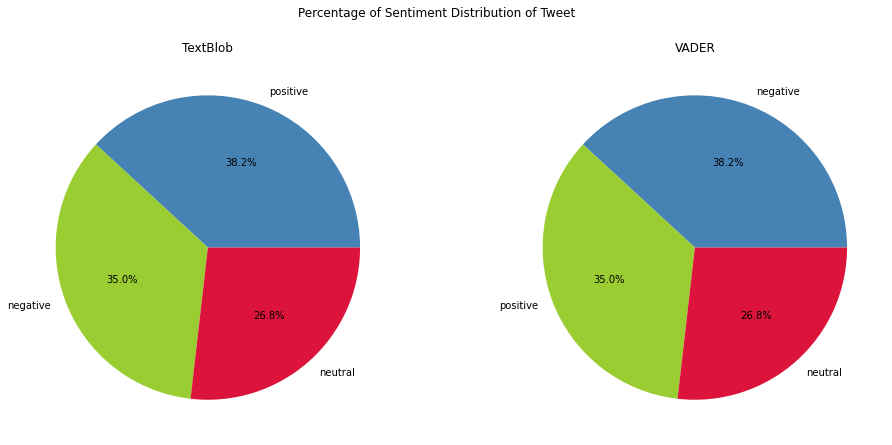

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Percentage of Sentiment Distribution of Tweet')

# TextBlob
perc = pd.DataFrame((unlabeled_df2['sent_predTextBlob'].value_counts()/len(unlabeled_df2))*100)
perc.reset_index(inplace=True)
perc.columns = ['Sentiment','Percentage']
axes[0].pie(perc['Percentage'],
        labels=perc['Sentiment'],
        autopct='%1.1f%%',
        colors=['steelblue','yellowgreen','crimson'])
axes[0].set_title("TextBlob")

# VADER
per = pd.DataFrame((unlabeled_df2['sent_pred'].value_counts()/len(unlabeled_df2))*100)
per.reset_index(inplace=True)
per.columns = ['Sentiment','Percentage']
axes[1].pie(perc['Percentage'],
        labels=per['Sentiment'],
        autopct='%1.1f%%',
        colors=['steelblue','yellowgreen','crimson'])
axes[1].set_title("VADER")
fig.show()

In [41]:
# unlabeled_df2.to_csv(path + "dataset/unlabeled_df2.csv", index=False)

In [42]:

untitled_negative=unlabeled_df2.loc[(unlabeled_df2.sent_pred=='negative')&
                   (unlabeled_df2.sent_predTextBlob=='negative')]

print(untitled_negative.shape)
untitled_negative.head()

(14809, 7)


,text,label,Clean_Tweets,sent_vader,sent_pred,sent_TextBlob,sent_predTextBlob
0,always made me feel worthless but all of a sud...,-1,always made feel worthless sudden problem,-0.6808,negative,-0.400000,negative
4,closer to killing myself everyday famsquad 💦 b...,-1,closer killing everyday famsquad mean also clo...,-0.6597,negative,-0.256250,negative
5,you know when life hits you hard and about kno...,-1,know life hit hard knock fuck like take world ...,-0.9370,negative,-0.365278,negative
6,the replies actually make me sick “he should e...,-1,reply actually make sick end yet first say ano...,-0.7778,negative,-0.266071,negative
7,it’s easier being alone but i’m tired of being...,-1,easier alone tired alone,-0.4767,negative,-0.400000,negative


In [43]:
untitled_positive = unlabeled_df2.loc[(unlabeled_df2.sent_pred=='positive')&
                   (unlabeled_df2.sent_predTextBlob=='positive')]

print(untitled_positive.shape)
untitled_positive.head()

(11846, 7)


,text,label,Clean_Tweets,sent_vader,sent_pred,sent_TextBlob,sent_predTextBlob
8,great game last night wished it had a better e...,-1,great game last night wished better ending hey...,0.8720,positive,0.320000,positive
12,turn it up louder are looking for new members ...,-1,turn louder looking new member join team wheth...,0.7717,positive,0.445455,positive
14,once you experience what its like to live unde...,-1,experience like live functional economy youll ...,0.3134,positive,0.068182,positive
28,happy birthday kim! as we get older and especi...,-1,happy birthday kim get older especially life g...,0.9618,positive,0.302646,positive
35,don’t give up trying to do what you really wan...,-1,give trying really want ella fitzgerald via,0.1513,positive,0.200000,positive


In [44]:
unlabeled_df = untitled_negative.append(untitled_positive, ignore_index=True)
unlabeled_df.shape

(26655, 7)

In [45]:
drop_cols=['label','Clean_Tweets','sent_vader','sent_pred','sent_TextBlob']
unlabeled_df=unlabeled_df.drop(columns=drop_cols)
unlabeled_df = unlabeled_df.rename(columns={'sent_predTextBlob':'label'})
print(unlabeled_df.label.value_counts())
unlabeled_df.info()

negative    14809
positive    11846
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26655 entries, 0 to 26654
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    26655 non-null  object
 1   label   26655 non-null  object
dtypes: object(2)
memory usage: 416.6+ KB


In [46]:
unlabeled_df.head()

,text,label
0,always made me feel worthless but all of a sud...,negative
1,closer to killing myself everyday famsquad 💦 b...,negative
2,you know when life hits you hard and about kno...,negative
3,the replies actually make me sick “he should e...,negative
4,it’s easier being alone but i’m tired of being...,negative


In [47]:
unlabeled_df.label = unlabeled_df.label.map({'negative':1, 'positive':0})

unlabeled_df.label.value_counts()

1    14809
0    11846
Name: label, dtype: int64

In [48]:
unlabeled_df.head()

,text,label
0,always made me feel worthless but all of a sud...,1
1,closer to killing myself everyday famsquad 💦 b...,1
2,you know when life hits you hard and about kno...,1
3,the replies actually make me sick “he should e...,1
4,it’s easier being alone but i’m tired of being...,1


In [49]:

len(unlabeled_df.text.unique())

25041

In [50]:
checkDuplicate(unlabeled_df)

Duplicate Rows except first occurrence based on all columns are :
                                                    text  label
12     to iruka "ill end this war myself! ill endure ...      1
32     [during sex] \r\n\r\nme i want you to hurt me\...      1
45     last religious tweet for today\r\n\r\ni have n...      1
46      vxi venting is saying “ugh my life sucks i’m ...      1
55     im so tired of everything being here is worthl...      1
...                                                  ...    ...
25838   sending positive vibes your way i hope you’ll...      0
25947  i want to die peacefully in my sleep like my g...      0
26301  my toxic trait i hurt in silence and pray that...      0
26366             i really don’t want to be here anymore      0
26457  better to fight for something than live for no...      0

[1614 rows x 2 columns]
(26655, 2)
(1614, 2)


In [51]:
unlabeled_df = unlabeled_df.drop_duplicates(keep='last')
unlabeled_df.shape

(25041, 2)

In [52]:
df = unlabeled_df.append(df_label, ignore_index=True)
df.shape

(34596, 2)

In [53]:
checkDuplicate(df)

Duplicate Rows except first occurrence based on all columns are :
                                                    text  label
7975                               i want to fucking die      1
25177  whats the alternative seriously i have chosen ...      1
25236  sorry in advance i am probably going to kill m...      1
25588  i am sad and tired i cant talk to someone and ...      1
25917  why stick around when i dont want to anymore a...      1
...                                                  ...    ...
33284                                 how to kill myself      1
33342  oh i ll never kill myself to save my soul i wa...      0
33351                                 how to kill myself      1
33655                           remember that i love you      0
33746                                                NaN      0

[83 rows x 2 columns]
(34596, 2)
(83, 2)


In [54]:
df = df.drop_duplicates(keep='last')
df.shape

(34513, 2)

In [55]:
missing_data_table(df)

,Total,Percent
text,1,0.000029
label,0,0.000000


In [56]:
df = df.dropna()

In [57]:
missing_data_table(df)

,Total,Percent
label,0,0.0
text,0,0.0


In [58]:
df.shape

(34512, 2)

In [59]:
df.label.value_counts()

1    18146
0    16366
Name: label, dtype: int64

In [60]:
df.to_csv(path + "dataset/created/without_unlabeled_df1.csv",index=False)

In [61]:
unlabeled_df1.head()

,text
0,If the people next door to me do not stop slam...
1,fell asleep for a 6 hour nap last week and @Ha...
2,i wanna fall asleep knowing you’re still in th...
3,Fall asleep and never wake up
4,wish i could just fall asleep and never wake up


In [62]:
stop_nltk= stopwords.words("english")
stop_updated= stop_nltk+["https",'t.co','...']
lemm= WordNetLemmatizer()
tweet_tok=  TweetTokenizer()

def clean_text(text):
    tokens= tweet_tok.tokenize(text.lower())
    tokens1 = [re.sub('^https://t.co/[\w]+','',tok) for tok in tokens]
    tokens2 = [re.sub('^@[\w]+','',tok) for tok in tokens1]
    tokens3 = [re.sub('^#[\w]+','',tok) for tok in tokens2]
    tokens4 = [re.sub('[0-9]+','',tok) for tok in tokens3]
    lemmed=[lemm.lemmatize(term) for term in tokens4 if term not in  stop_updated and term not in list(punctuation) and len(term)>2]
    res=' '.join(lemmed)
    return res

In [63]:
unlabeled_df1['text'] = unlabeled_df1['text'].astype(str)
unlabeled_df1['Clean_Tweets']= unlabeled_df1['text'].apply(clean_text)

In [64]:
unlabeled_df1.head()

,text,Clean_Tweets
0,If the people next door to me do not stop slam...,people next door stop slamming door gonna abba...
1,fell asleep for a 6 hour nap last week and @Ha...,fell asleep hour nap last week worried might n...
2,i wanna fall asleep knowing you’re still in th...,wanna fall asleep knowing still phone wake see...
3,Fall asleep and never wake up,fall asleep never wake
4,wish i could just fall asleep and never wake up,wish could fall asleep never wake


In [65]:
analyser= SentimentIntensityAnalyzer() 

def get_vader_sentiment(sent):
    return analyser.polarity_scores(sent)['compound']

unlabeled_df1['sent_vader']= unlabeled_df1['Clean_Tweets'].apply(get_vader_sentiment)

sent_pred=[]
for i in range(len(unlabeled_df1['sent_vader'])):
    if unlabeled_df1['sent_vader'][i]>=0.05:
        sent_pred.append('positive')
    elif unlabeled_df1['sent_vader'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

unlabeled_df1['sent_pred']= sent_pred

In [66]:
def get_textblob_sentiment(sent):
    return TextBlob(sent).sentiment.polarity


unlabeled_df1['sent_TextBlob']= unlabeled_df1['Clean_Tweets'].apply(get_textblob_sentiment)

sent_pred=[]
for i in range(len(unlabeled_df1['sent_TextBlob'])):
    if unlabeled_df1['sent_TextBlob'][i]>=0.05:
        sent_pred.append('positive')
    elif unlabeled_df1['sent_TextBlob'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

unlabeled_df1['sent_predTextBlob']= sent_pred


In [67]:
unlabeled_df1.head()

,text,Clean_Tweets,sent_vader,sent_pred,sent_TextBlob,sent_predTextBlob
0,If the people next door to me do not stop slam...,people next door stop slamming door gonna abba...,0.5423,positive,0.066667,positive
1,fell asleep for a 6 hour nap last week and @Ha...,fell asleep hour nap last week worried might n...,-0.2960,negative,0.000000,neutral
2,i wanna fall asleep knowing you’re still in th...,wanna fall asleep knowing still phone wake see...,0.0000,neutral,0.000000,neutral
3,Fall asleep and never wake up,fall asleep never wake,0.0000,neutral,0.000000,neutral
4,wish i could just fall asleep and never wake up,wish could fall asleep never wake,0.4019,positive,0.000000,neutral


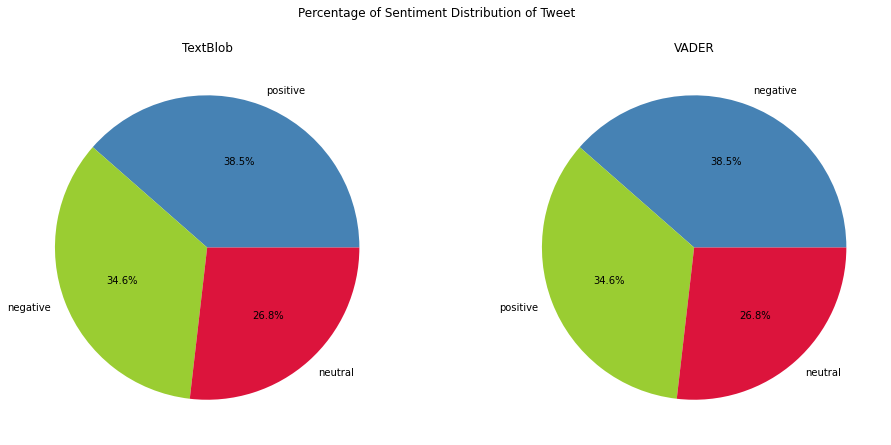

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Percentage of Sentiment Distribution of Tweet')

# TextBlob
perc = pd.DataFrame((unlabeled_df1['sent_predTextBlob'].value_counts()/len(unlabeled_df1))*100)
perc.reset_index(inplace=True)
perc.columns = ['Sentiment','Percentage']
axes[0].pie(perc['Percentage'],
        labels=perc['Sentiment'],
        autopct='%1.1f%%',
        colors=['steelblue','yellowgreen','crimson'])
axes[0].set_title("TextBlob")

# VADER
per = pd.DataFrame((unlabeled_df1['sent_pred'].value_counts()/len(unlabeled_df1))*100)
per.reset_index(inplace=True)
per.columns = ['Sentiment','Percentage']
axes[1].pie(perc['Percentage'],
        labels=per['Sentiment'],
        autopct='%1.1f%%',
        colors=['steelblue','yellowgreen','crimson'])
axes[1].set_title("VADER")
fig.show()

In [69]:
untitled_negative_df1=unlabeled_df1.loc[(unlabeled_df1.sent_pred=='negative')&
                   (unlabeled_df1.sent_predTextBlob=='negative')]

print(untitled_negative_df1.shape)
untitled_negative_df1.head()

(14784, 6)


,text,Clean_Tweets,sent_vader,sent_pred,sent_TextBlob,sent_predTextBlob
7,The problem with sleeping is I can never fall ...,problem sleeping never fall asleep wake consta...,-0.8020,negative,-0.100000,negative
11,"""he was afraid to fall asleep\nfor fear he’d n...",afraid fall asleep fear never wake morning arr...,-0.4019,negative,-0.600000,negative
12,i wish that i could wake up with amnesia and f...,wish could wake amnesia forget stupid little t...,-0.2255,negative,-0.329167,negative
15,I wish that I could wake up with amnesia\nAnd ...,wish could wake amnesia forget stupid little t...,-0.2255,negative,-0.329167,negative
17,This is the face of depression and mental illn...,face depression mental illness sleeping two af...,-0.5267,negative,-0.100000,negative


In [70]:
untitled_positive_df1 = unlabeled_df1.loc[(unlabeled_df1.sent_pred=='positive')&
                   (unlabeled_df1.sent_predTextBlob=='positive')]

print(untitled_positive_df1.shape)
untitled_positive_df1.head()

(12302, 6)


,text,Clean_Tweets,sent_vader,sent_pred,sent_TextBlob,sent_predTextBlob
0,If the people next door to me do not stop slam...,people next door stop slamming door gonna abba...,0.5423,positive,0.066667,positive
6,that #relatable moment when sadnes consumes yo...,moment sadnes consumes wanna curl ball corner ...,0.4588,positive,0.550000,positive
8,All day I've waited for the kids to go to bed ...,day i've waited kid bed could quiet time they'...,0.8192,positive,0.262500,positive
18,I wish to fall asleep in your arms and wake up...,wish fall asleep arm wake warm heart knowing d...,0.8225,positive,0.475000,positive
19,I wish to fall asleep in your arms and wake up...,wish fall asleep arm wake warm heart knowing d...,0.8225,positive,0.475000,positive


In [71]:
unlabeled_df1 = untitled_negative_df1.append(untitled_positive_df1, ignore_index=True)
unlabeled_df1.shape

(27086, 6)

In [72]:
drop_cols=['Clean_Tweets','sent_vader','sent_pred','sent_TextBlob']
unlabeled_df1=unlabeled_df1.drop(columns=drop_cols)
unlabeled_df1 = unlabeled_df1.rename(columns={'sent_predTextBlob':'label'})
print(unlabeled_df1.label.value_counts())
unlabeled_df1.info()

negative    14784
positive    12302
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27086 entries, 0 to 27085
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27086 non-null  object
 1   label   27086 non-null  object
dtypes: object(2)
memory usage: 423.3+ KB


In [73]:

len(unlabeled_df1.text.unique())

25925

In [74]:
checkDuplicate(unlabeled_df1)

Duplicate Rows except first occurrence based on all columns are :
                                                    text     label
4      This is the face of depression and mental illn...  negative
43     Might fuck around and fall asleep and never wa...  negative
62             I’m so tired I just want to sleep forever  negative
65     it just hurts so bad and i really don’t believ...  negative
123    i just want to sleep forever because dealing w...  negative
...                                                  ...       ...
26304  誰かの為に生きてこそ、人生には価値がある。\n\nLife isn’t worth livi...  positive
26342  誰かの為に生きてこそ、人生には価値がある。\n\nLife isn’t worth livi...  positive
26519  "My heart fills up with love, love and I want ...  positive
26555  I’m at a point in my life where I just want to...  positive
26556  I’m at a point in my life where I just want to...  positive

[1161 rows x 2 columns]
(27086, 2)
(1161, 2)


In [75]:
unlabeled_df1 = unlabeled_df1.drop_duplicates(keep='last')
unlabeled_df1.shape


(25925, 2)

In [76]:
checkDuplicate(unlabeled_df1)


Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [text, label]
Index: []
(25925, 2)
(0, 2)


In [77]:
unlabeled_df1.shape

(25925, 2)

In [78]:
unlabeled_df1.to_csv(path + "dataset/created/with_unlabeled_df1.csv",index=False)